In [1]:
import pandas as pd

In [51]:
data  = pd.read_csv('monthly-beer-production-in-austr.csv', parse_dates=['Month'], 
                   index_col='Month')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Monthly beer production in Australia  476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


In [55]:
data.columns = ['Production']

### Step:1 Visualize and check for trends

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10,5

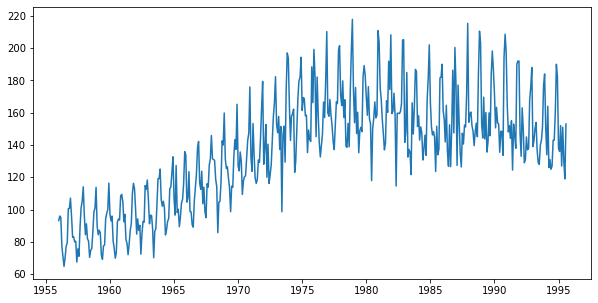

In [29]:
plt.plot(data)

- the data looks stationary format, with uptrend and seems to have 5 seasons in a year

### Step:2 stationary check and  differencing

In [53]:
# Testing for stationarity

from statsmodels.tsa.stattools import adfuller

In [56]:
test_result = adfuller(data['Production']) 

In [58]:
#Ho: it is non-stationary (null hypothesis)
#H1: it is stationary

def adfuller_test(timeseries):
    
    result = adfuller(timeseries)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations used']
    

    for value, label in zip(result,labels):
            print(label+':'+str(value))
            
    if result[1] <= 0.05:
        print('strong evidence against null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [59]:
adfuller_test(data['Production']) 

ADF Test Statistic:-2.2826614187875722
p-value:0.17762099829132666
#Lags Used:17
Number of Observations used:458
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


we accept null-hypothesis and proceed with differencing in order to change the pvale to stationarise the series

### Differencing

In [61]:
data['Sales First Difference'] = data['Production'] - data['Production'].shift(1)

In [62]:
data['Seasonal First Difference'] = data['Production'] - data['Production'].shift(12)

In [70]:
# reapply using duckey-fuller test again
adfuller_test(data['Seasonal First Difference'].dropna())

ADF Test Statistic:-2.8967624777519863
p-value:0.04572577462359892
#Lags Used:17
Number of Observations used:446
strong evidence against null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Month'>

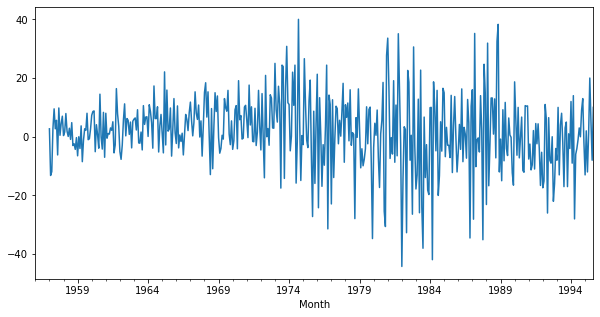

In [71]:
data['Seasonal First Difference'].plot()

### Step: 3 plot ACF/PACF

#### Stationarity

A common assumption in many time series techniques is that the data are stationary. A stationary process has the property that the mean, variance and autocorrelation structure do not change over time.

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

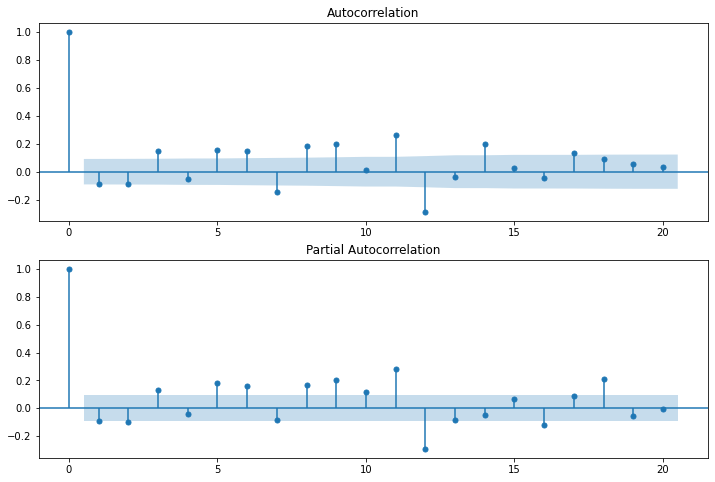

In [76]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211) # opsition of the sublot
fig = plot_acf(data['Seasonal First Difference'].iloc[13:], lags=20, ax=ax1) # 1st 12 values are NaN
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Seasonal First Difference'].iloc[13:], lags=20, ax=ax2)

- AR = p = 1 (in here PACF shuts off at 1)
- MA = q = 1 (tapers toward 0)
-      d = 1 (seasonal differencing was worked out at 1time) 

### Step: 4 Build SARIMA model

In [133]:
import statsmodels.api as sm

In [134]:
model=sm.tsa.statespace.SARIMAX(data['Production'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

C:\Users\jaiha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jaiha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Month'>

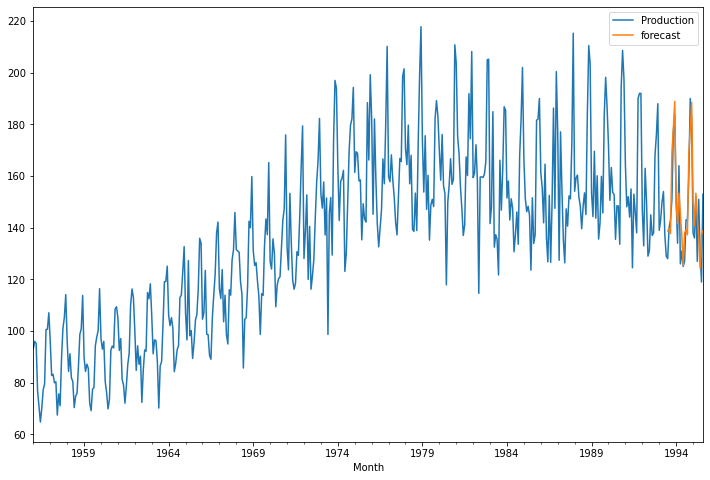

In [135]:
data['forecast'] = results.predict(start=450,end=476,dynamic=True)
data[['Production','forecast']].plot(figsize=(12,8))

#### getting a closer look

<AxesSubplot:xlabel='Month'>

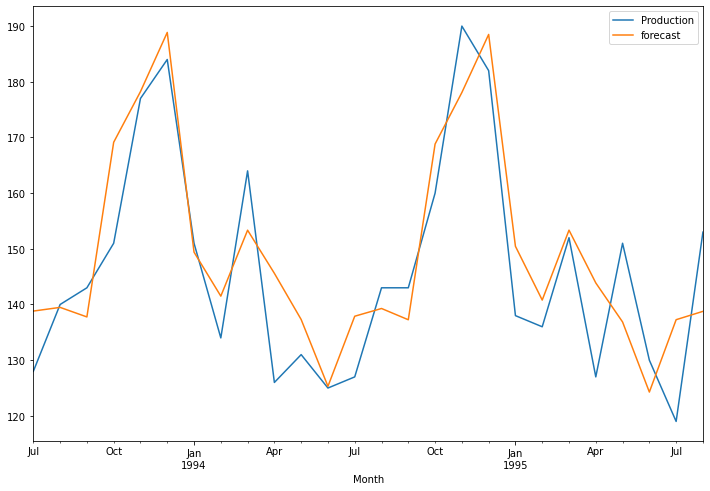

In [136]:
data[['Production','forecast']].iloc[450:476].plot(figsize=(12,8))

### Step:5 Future Prediction

In [137]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+DateOffset(months=x)for x in range(0,24)]

In [138]:
future_date_data = pd.DataFrame(index=future_dates[1:],columns=data.columns)

In [139]:
future_data = pd.concat([data,future_date_data])

In [140]:
future_data.shape

(499, 4)

<AxesSubplot:>

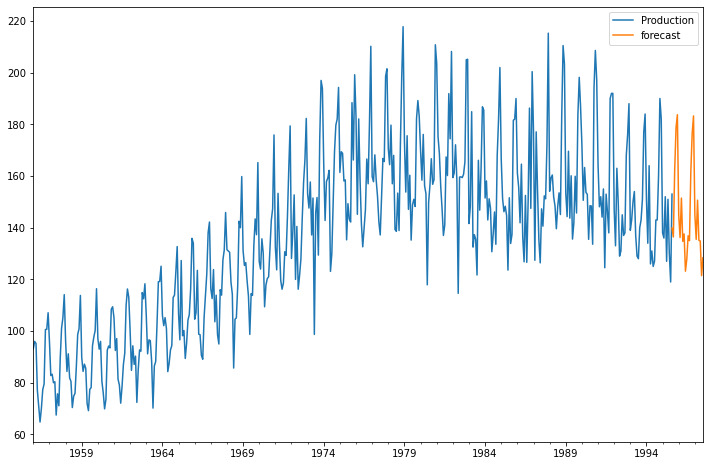

In [141]:
future_data['forecast'] = results.predict(start=475,end=499,dynamic=True)
future_data[['Production','forecast']].plot(figsize=(12,8))

#### getting a closer look

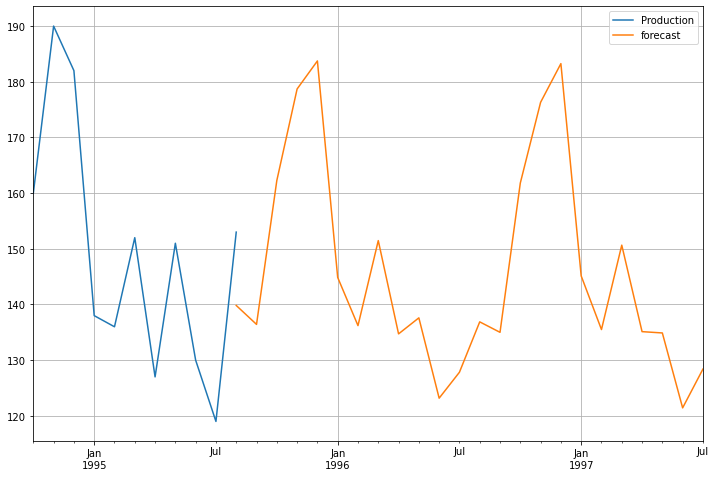

In [142]:
future_data[['Production','forecast']].iloc[465:499].plot(figsize=(12,8))
plt.grid()